# Perception & Deep Learning

In [438]:
import matplotlib.pyplot as plt
import numpy as np

# torch imports
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

## Neurale netwerken in Pytorch

In [467]:
from sklearn.datasets import make_moons

class CustomDataset(Dataset):
    def __init__(self, n_samples, noise) -> None:
        super().__init__()
        self.X, self.y = make_moons(n_samples=n_samples, noise=noise)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

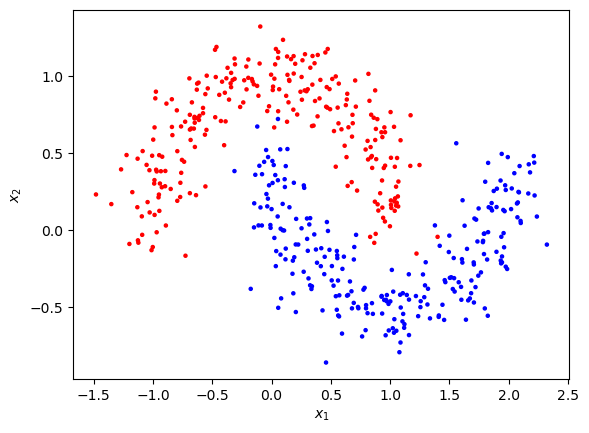

In [515]:
from matplotlib.colors import ListedColormap

col_palette = ['r', 'b']
cmap = ListedColormap(col_palette)

dataset = CustomDataset(n_samples=500, noise=0.15)
train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])

plt.scatter(x=dataset.X[:, 0], y=dataset.X[:, 1], s=5, c=dataset.y, cmap=cmap)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.show()

**Binair classificatie probleem** 
- Modelleren van een kansverdeling: $p(y=\text{red} | x)$
- Andersom: $p(y=\text{blue} | x) = 1 - p(y=\text{red} | x)$
- Gebruik sigmoid om laatste laag te transformeren naar kansverdeling 
- (kansen moeten voldoen aan $\sum_x p(x) = 1$)

In [525]:
n_hidden_units = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = nn.Sequential(
    nn.Linear(in_features=2, out_features=n_hidden_units),
    nn.ReLU(),
    nn.Linear(in_features=n_hidden_units, out_features=2),
    nn.ReLU(),
    nn.Linear(in_features=2, out_features=1),
    nn.Sigmoid()
).to(device)

criterion = nn.BCELoss()
optim = torch.optim.Adam(net.parameters(), lr=0.01)

train_history = []
val_history = []

net

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=1, bias=True)
  (5): Sigmoid()
)

In [526]:
features = {} # dictionary to store intermediate results

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

handle1 = net[2].register_forward_hook(get_features("linear_layer"))
handle2 = net[3].register_forward_hook(get_features("relu_layer"))

# gebruikt om training proces te visualiseren
hidden_linear_vals = []
hidden_relu_vals = []

### Training loop

epoch: 0	train loss: 0.0566	val loss: 0.0785
epoch: 10	train loss: 0.0545	val loss: 0.0759
epoch: 20	train loss: 0.0526	val loss: 0.0738
epoch: 30	train loss: 0.0507	val loss: 0.0719
epoch: 40	train loss: 0.0490	val loss: 0.0699
epoch: 50	train loss: 0.0474	val loss: 0.0681
epoch: 60	train loss: 0.0459	val loss: 0.0662
epoch: 70	train loss: 0.0444	val loss: 0.0647
epoch: 80	train loss: 0.0431	val loss: 0.0630
epoch: 90	train loss: 0.0418	val loss: 0.0619


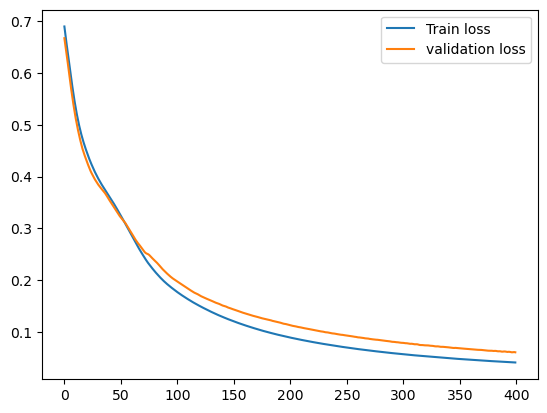

In [530]:
EPOCHS = 100

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))
val_loader = DataLoader(val, batch_size=len(val))

for e in range(EPOCHS):
    ### TRAIN
    batch_losses = []
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(-1)
        # forward pass
        y_preds = net(batch_x)
        loss = criterion(y_preds, batch_y)
        # backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # save loss value
        batch_losses.append(loss.item())
        hidden_linear_vals.append([features['linear_layer'], batch_y])
        hidden_relu_vals.append([features['relu_layer'], batch_y])
    
    train_history.append(np.mean(batch_losses))

    ### VALIDATE
    batch_losses = []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(-1)
            y_preds = net(batch_x)
            loss = criterion(y_preds, batch_y)
            batch_losses.append(loss.item())
    val_history.append(np.mean(batch_losses))

    if e % 10 == 0: print(f"epoch: {e}\ttrain loss: {train_history[-1]:.4f}\tval loss: {val_history[-1]:.4f}")

plt.plot(train_history, label='Train loss')
plt.plot(val_history, label='validation loss')
plt.legend()

In [531]:
### TEST
with torch.no_grad():
    test_loss = 0
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device).unsqueeze(-1)
        y_preds = net(batch_x)
        loss = criterion(y_preds, batch_y)
        test_loss += loss.item()
    print(f"test loss: {test_loss / len(test_loader)}")

test loss: 0.09238849580287933


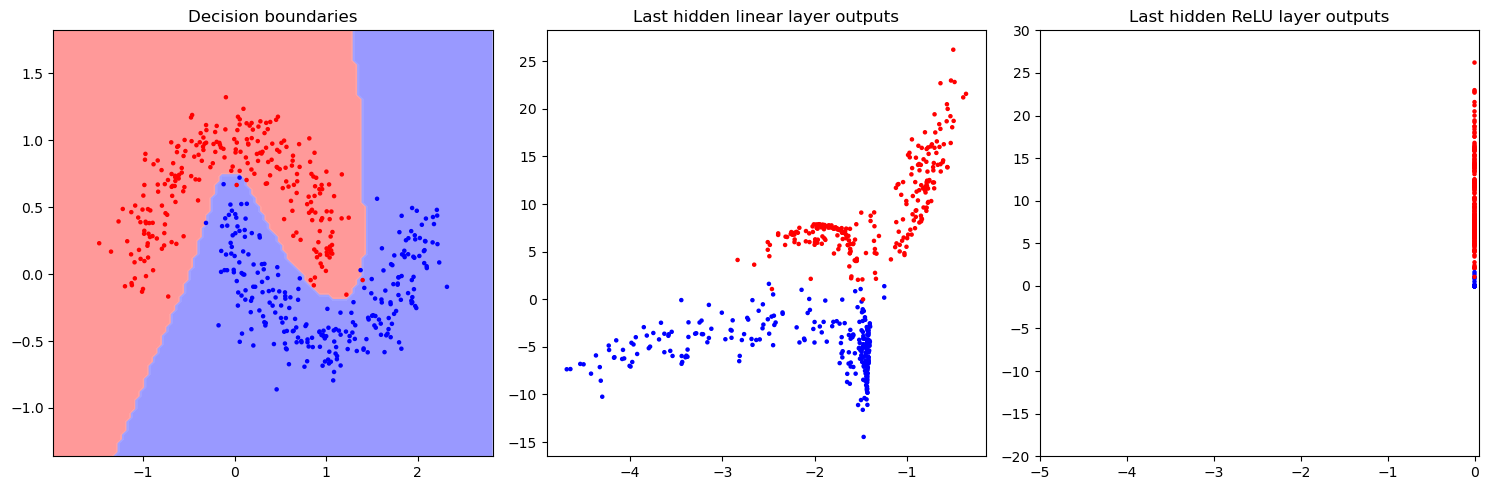

In [543]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# maak meshgrid om beslisgrenzen te laten zien
xmin = dataset.X[:, 0].min(); xmax = dataset.X[:, 0].max()
ymin = dataset.X[:, 1].min(); ymax = dataset.X[:, 1].max()
xx, yy = torch.meshgrid(
    torch.linspace(xmin-.5, xmax+.5, 100),
    torch.linspace(ymin-.5, ymax+.5, 100)
)
D = torch.vstack((xx.flatten(), yy.flatten())).T

# contour
y_cont = net(D.to('cuda')).cpu()
y_cont = (y_cont > 0.5)*1

# dataset
_ = net(dataset.X.to('cuda')).cpu()
h_data = features['linear_layer'].cpu()
r_data = features['relu_layer'].cpu()

# plot on both axes
ax1.contourf(xx.numpy(), yy.numpy(), y_cont.reshape(xx.shape), cmap=cmap, alpha=0.4, antialiased=True)
ax1.scatter(dataset.X[:, 0], dataset.X[:, 1], s=5, c=dataset.y, cmap=cmap)
ax1.set_title("Decision boundaries")

ax2.scatter(h_data[:, 0], h_data[:, 1], s=5, c=dataset.y, cmap=cmap)
ax2.set_title("Last hidden linear layer outputs")

ax3.scatter(r_data[:, 0], r_data[:, 1], s=5, c=dataset.y, cmap=cmap)
ax3.set_title("Last hidden ReLU layer outputs")

ax3.set_xticks(ax2.get_xticks())
ax3.set_yticks(ax2.get_yticks())

plt.tight_layout()

Onderstaande code kan gebruikt worden om het leer proces te visualiseren

In [ ]:
# from matplotlib import animation

# fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True)
# ax.set_xlabel(r'$h_1$')
# ax.set_ylabel(r'$h_2$')
# # sc = ax.scatter([], [])

# def animate(i):
#     # global sc
#     x = hidden_linear_vals[i][0].cpu()
#     y = hidden_linear_vals[i][1].cpu()
#     ax.clear()
#     # sc.set_alpha(0.2)
#     sc = ax.scatter(x=x[:, 0], y=x[:, 1], s=5, c=y, cmap=cmap)
#     ax.set_title(f'Learning process epoch={i}')
#     return sc

# anim = animation.FuncAnimation(fig, animate, frames=len(hidden_linear_vals), repeat=False, interval=1)
# anim.save('data/training_animation.mp4', writer=animation.FFMpegWriter(fps=10))

## Opdracht: Histogram of Oriented Gradients

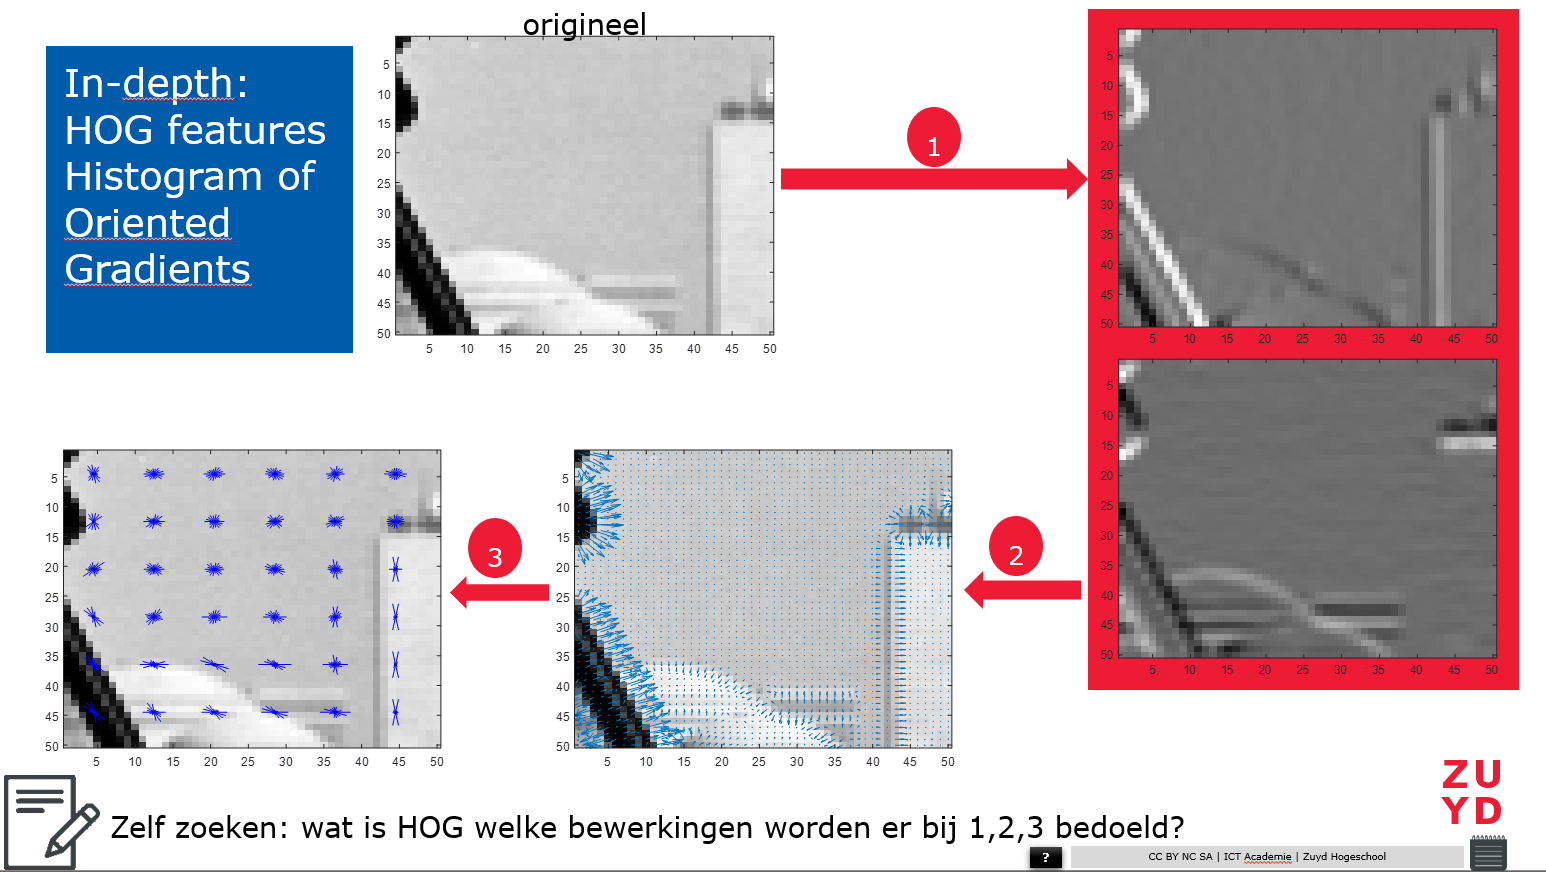

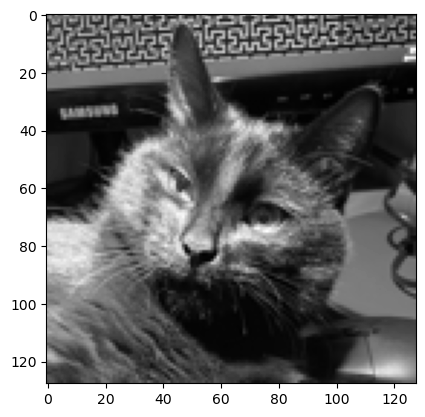

In [609]:
from PIL import Image

img = Image.open('data/kat.png')
img.load()
img = img.resize((128, 128))
img = torch.tensor(np.asarray(img, dtype='int32'))  # convert to torch tensor
img = img.mean(dim=2, dtype=torch.float32)          # make gray-scale

plt.imshow(img, cmap="gray")

**Filters/kernels**
- sliding window
- horizontaal: 
  $$K_h = \begin{bmatrix} -1 & 0 & 1 \end{bmatrix}$$
- verticaal: 
  $$K_v = \begin{bmatrix}-1\\ 0\\ 1 \end{bmatrix}$$
- Voorbeeld: gegeven een window $W = \begin{bmatrix} 50 & 40 & 30 \end{bmatrix}$ kunnen we $K_h$ toepassen:
  $$\underbrace{W \cdot K_h}_{\text{dot-product}} = 50 \times -1 + 40 \times 0 + 30 \times 1 = -50 + 30 = -20$$
- Dit geeft de horizontale en verticale gradienten (hoeveelheid verandering)

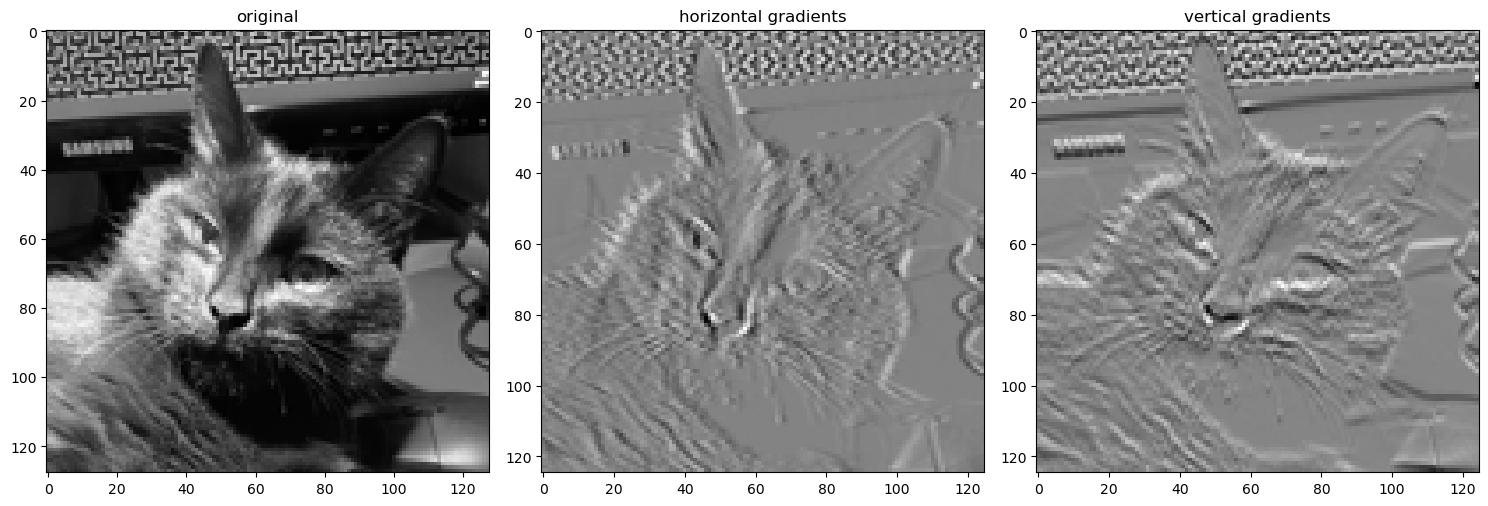

In [658]:
n = 3
kernel = torch.tensor([
    [-1, 0, 1]
])

grad_x = torch.zeros(img.shape[0]-n, img.shape[1]-n)
grad_y = torch.zeros(img.shape[0]-n, img.shape[1]-n)

for j in range(img.shape[0]-n):
    for i in range(img.shape[1]-n):
        grad_x[j, i] = torch.sum(img[j, i:i+n] * kernel)
        grad_y[j, i] = torch.sum(img[j:j+n, i] * kernel)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img, cmap="gray")
ax1.set_title("original")

ax2.imshow(grad_x, cmap="gray")
ax2.set_title("horizontal gradients")

ax3.imshow(grad_y, cmap="gray")
ax3.set_title("vertical gradients")
plt.tight_layout()

**Orientation & magnitude**
- ieder paar gradienten $(g_x, g_y)$ kunnen we zien als 2D-vector (een pijl)
- orientation is de richting van de gradienten (richting van de pijl)
- magnitude is de lengte van de gradienten (lengte van de pijl)

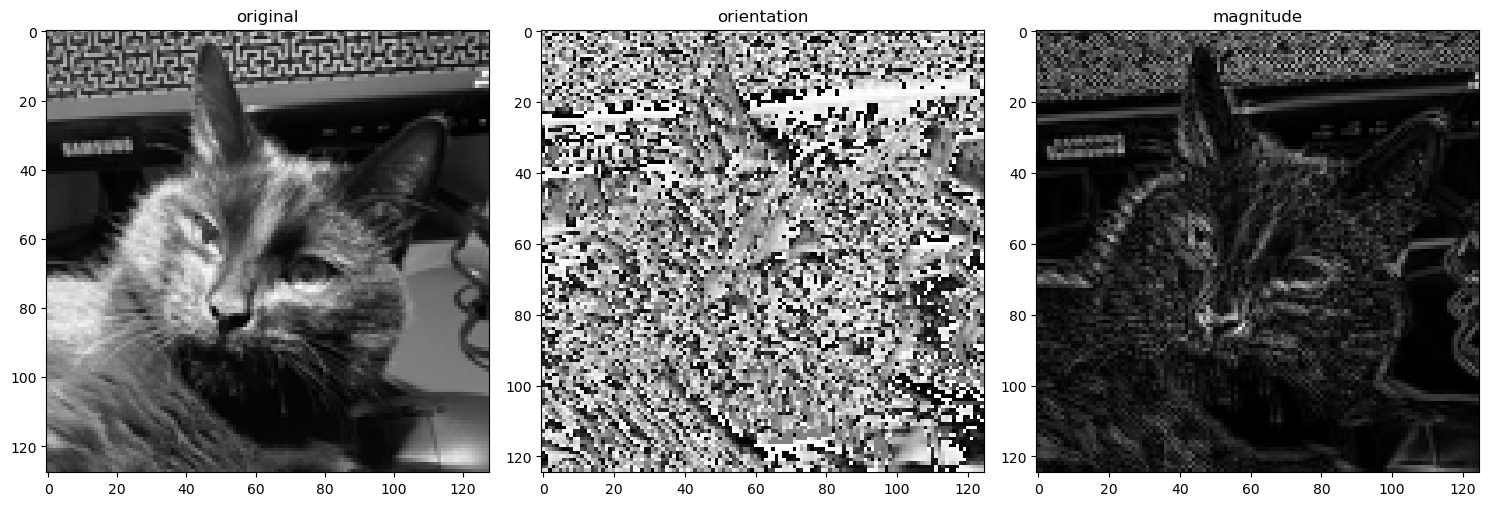

In [657]:
orientation = torch.arctan(grad_y / (grad_x + 1e-8))
magnitude = torch.sqrt(grad_x**2 + grad_y**2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(img, cmap="gray")
ax1.set_title("original")

ax2.imshow(orientation, cmap="gray")
ax2.set_title("orientation")

ax3.imshow(magnitude, cmap="gray")
ax3.set_title("magnitude")
plt.tight_layout()

**Algoritme HOG**
- Voor ieder $8\times 8$ (niet-overlappende) patch, maken we een histogram van richtingen (orientations) met $9$ bins
- Deze worden gevuld door de corresponderende magnitude en orientation matrix

In [654]:
cell_orientation = orientation[:8, :8]
cell_magnitude = magnitude[:8, :8]

n_bins = 9
delta_bin = 2*np.pi/n_bins
hist_bins = torch.tensor([delta_bin * i for i in range(1, n_bins+1)])
HOG_block_hist = torch.zeros(hist_bins.shape[0])

for j in range(8):
    for i in range(8):
        curr_orientation = cell_orientation[j, i]
        curr_magnitude = cell_magnitude[j, i]

        diff = torch.abs(curr_orientation - hist_bins)
        
        if curr_orientation < hist_bins[0]: # if out of range
            first_bin_idx = 0
            second_bin_idx = n_bins-1
        elif curr_orientation > hist_bins[-1]: # if out of range
            first_bin_idx = n_bins-1
            second_bin_idx = 0
        else:
            first_bin_idx = torch.where(diff == torch.min(diff))[0][0]
            temp = hist_bins[(first_bin_idx-1)%n_bins]
            temp2 = torch.abs(curr_orientation - temp)
            res = torch.where(temp2 == torch.min(temp2))[0][0]
            if res == 0 and first_bin_idx != 0:
                second_bin_idx = first_bin_idx-1
            else:
                second_bin_idx = first_bin_idx+1
        
        first_bin_value = hist_bins[first_bin_idx]
        second_bin_value = hist_bins[second_bin_idx]
        HOG_block_hist[first_bin_idx] = HOG_block_hist[first_bin_idx] + (torch.abs(curr_orientation - first_bin_value)/delta_bin) * curr_magnitude
        HOG_block_hist[second_bin_idx] = HOG_block_hist[second_bin_idx] + (torch.abs(curr_orientation - second_bin_value)/delta_bin) * curr_magnitude

# normalize HOG
HOG_block_hist = HOG_block_hist / torch.sum(HOG_block_hist**2)**0.5
HOG_block_hist

tensor([0.1733, 0.0471, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9837])

In [571]:
!pip install scikit-image

   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   - -------------------------------------- 0.7/24.5 MB 14.2 MB/s eta 0:00:02
   -- ------------------------------------- 1.4/24.5 MB 17.6 MB/s eta 0:00:02
   --- ------------------------------------ 2.1/24.5 MB 16.5 MB/s eta 0:00:02
   ---- ----------------------------------- 2.8/24.5 MB 16.0 MB/s eta 0:00:02
   ----- ---------------------------------- 3.5/24.5 MB 15.7 MB/s eta 0:00:02
   ------ --------------------------------- 4.2/24.5 MB 15.6 MB/s eta 0:00:02
   ------- -------------------------------- 4.8/24.5 MB 15.4 MB/s eta 0:00:02
   --------- ------------------------------ 5.6/24.5 MB 15.4 MB/s eta 0:00:02
   ---------- ----------------------------- 6.3/24.5 MB 15.4 MB/s eta 0:00:02
   ----------- ---------------------------- 7.0/24.5 MB 15.4 MB/s eta 0:00:02
   ------------ --------------------------- 7.7/24.5 MB 15.3 MB/s eta 0:00:02
   ------------- -------------------------- 8.4/24.5 MB 15.3 MB/s eta 0:

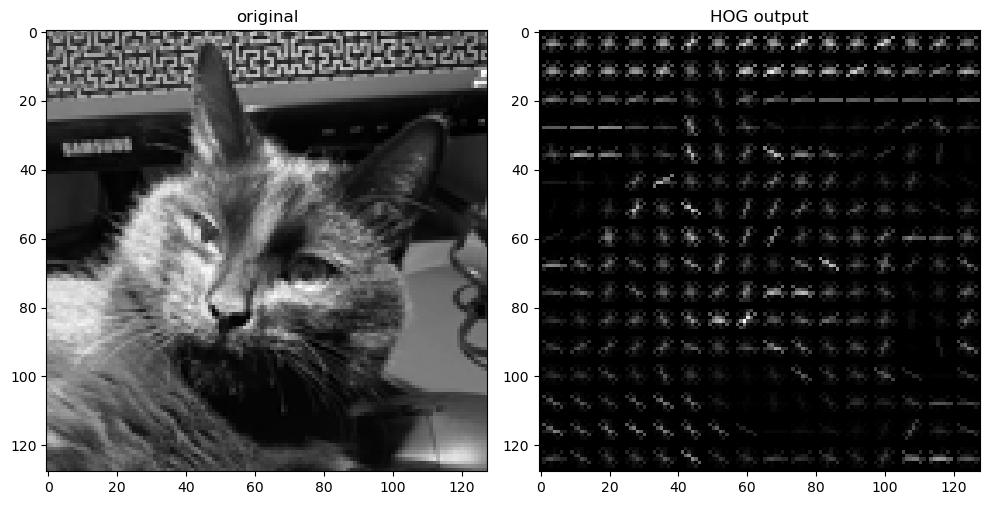

In [660]:
from skimage.feature import hog

hog_features, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img, cmap="gray")
ax1.set_title("original")

ax2.imshow(hog_image, cmap="gray")
ax2.set_title("HOG output")
plt.tight_layout()

In [665]:
hog_features.shape, 128**2 # HOG features 

((2304,), 16384)

**Interpretatie HOG:**
- lange en intense pijlen zeggen dat er veel verandering is in image waarden
- compacte representatie van een afbeelding (ipv $128\times 128$ features zijn er maar $2304$ features)
- feature engineering methode voor afbeeldingen
- HOG features gebruiken om afbeeldingen te classificeren/detecteren 

## Convolutional Neural Networks

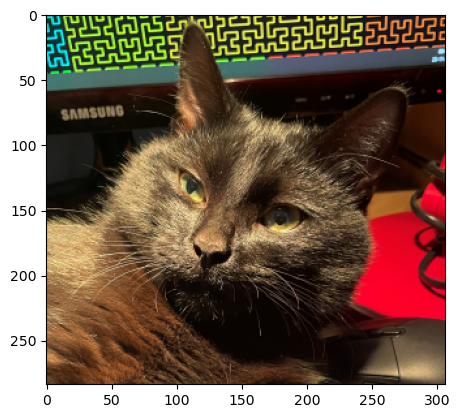

In [671]:
from PIL import Image

img = Image.open('data/kat.png')
img.load()
img = torch.tensor(np.asarray(img, dtype='int32'))  # convert to torch tensor

plt.imshow(img, cmap="gray")

**Parameters van convolutie (2D cross-correlatie):**
- kernel shape $(H_k \times W_k)$
- padding shape $(H_p \times  W_p)$
- stride shape $(H_s \times  W_s)$

Na het toepassen van een kernel op een afbeelding $A$ met shape $(H \times  W)$ wordt de nieuwe shape van de afbeelding:
$$
    A_{\text{nieuw}}: \left(\dfrac{H - H_k + H_p + H_s}{H_s} \times \dfrac{W - W_k + W_p + W_s}{W_s} \right)
$$


In [694]:
def map_val(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def conv2d(
        X: torch.Tensor, 
        kernel: torch.Tensor,       # kernel: (k_dim, height, width)
        padding: tuple[int, int], 
        stride: tuple[int, int], 
        k_dim: int) -> torch.Tensor:
    # input: (height, width, num_channels)
    ph, pw = padding
    sh, sw = stride
    _, kh, kw = kernel.shape
    X_padded = torch.zeros(X.shape[0]+2*ph, X.shape[1]+2*pw, X.shape[2]) # create padded X
    X_padded[ph:-ph, pw:-pw, :] = X # embed X into padded X
    # create output shape
    H = torch.zeros((X_padded.shape[0]-kh+ph+sh)//sh, (X_padded.shape[1]-kw+pw+sw)//sw, X_padded.shape[2])

    for j in range(H.shape[0]):
        for i in range(H.shape[1]):
            for c in range(H.shape[2]):
                try:
                    H[j, i, c] = torch.sum(X_padded[j*sh:j*sh+kh, i*sw:i*sw+kw, c] * kernel[k_dim, :, :])
                except: # strided tensor size not the same as kernel size
                    pass
                
    # output: (height, width, num_channels)
    return H

X = img
kernel = torch.tensor([[
    [10, 0, 10],
    [10, 0, 10],
    [10, 0, 10]
]])
padding = (1, 1)
stride = (1, 1)
conv_X = conv2d(X, kernel, padding, stride, 0)

for k in range(conv_X.shape[2]):
    conv_X[:, :, k] = map_val(conv_X[:, :, k], conv_X[:, :, k].min(), conv_X[:, :, k].max(), 0, 1)

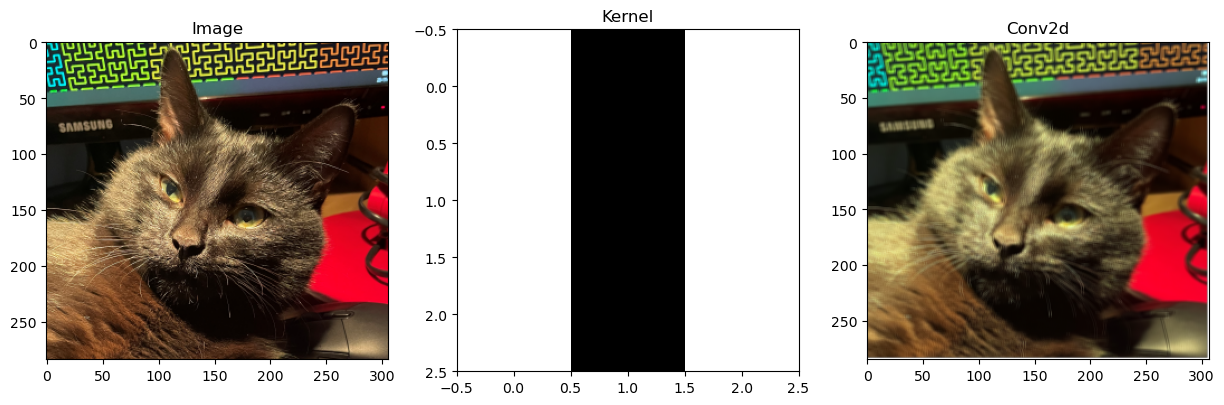

In [696]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(img, cmap="gray")
ax1.set_title("Image")
ax2.imshow(kernel.squeeze(), cmap="gray")
ax2.set_title("Kernel")
ax3.imshow(conv_X, cmap="gray")
ax3.set_title("Conv2d")

plt.show()

### Implementatie LeNet

- Eerste CNN publicatie door Yan LeCun et al.
- http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf 

In [741]:
lenet = nn.Sequential(
    # conv block 1: 28 -> 12
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),   # 28 -> 24
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),                                          # 24 -> 12
    # conv block 2: 12 -> 4
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),  # 12 -> 8
    nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),                                          # 8 -> 4
    # dense MLP
    nn.Flatten(),                                                                   # 16*4*4 = 256 units
    nn.Linear(256, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10) # 10 classes in MNIST
).to(device)

X = torch.randn(1, 1, 28, 28).to(device)
lenet(X).shape

torch.Size([1, 10])

### Laad train/test sets

In [742]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # normalize [0, 1]
])

train = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_val = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
test, val = torch.utils.data.random_split(test_val, [0.5, 0.5])

### Training loop

epoch: 0	train loss: 1.3145	val loss: 0.3273
epoch: 1	train loss: 0.2321	val loss: 0.1704
epoch: 2	train loss: 0.1399	val loss: 0.1136
epoch: 3	train loss: 0.1042	val loss: 0.0877
epoch: 4	train loss: 0.0847	val loss: 0.0821
epoch: 5	train loss: 0.0728	val loss: 0.0690
epoch: 6	train loss: 0.0642	val loss: 0.0602
epoch: 7	train loss: 0.0577	val loss: 0.0603
epoch: 8	train loss: 0.0514	val loss: 0.0606
epoch: 9	train loss: 0.0477	val loss: 0.0597


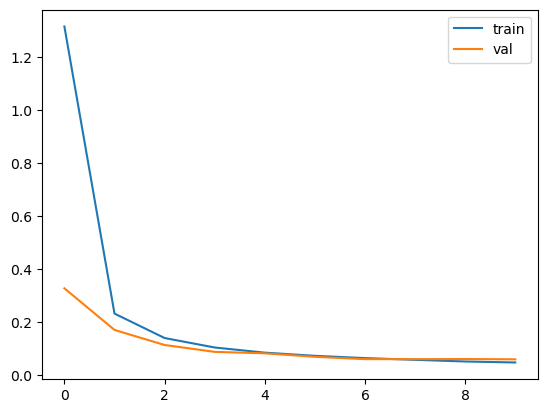

In [743]:
EPOCHS = 5

train_loader = DataLoader(train, batch_size=128, shuffle=True)
test_loader = DataLoader(test, batch_size=len(test), shuffle=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=True)

optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_history = []
val_history = []

for e in range(EPOCHS):
    batch_history = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # predict and compute loss
        preds = lenet(images)
        loss = criterion(preds, labels)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_history.append(np.mean(batch_history))

    batch_history = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = lenet(images)
            loss = criterion(preds, labels)
            batch_history.append(loss.item())
        val_history.append(np.mean(batch_history))
    
    print(f"epoch: {e}\ttrain loss: {train_history[-1]:.4f}\tval loss: {val_history[-1]:.4f}")

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

In [744]:
with torch.no_grad():
    test_loss = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        preds = lenet(images)
        loss = criterion(preds, labels)
        test_loss += loss.item()
    print(f"test loss: {test_loss / len(test_loader)}")

test loss: 0.05967578664422035


### Visualiseren van CNN

In [745]:
features = {} #dictionary that will store results!

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

hook_handles = []

In [746]:
for i, m in enumerate(lenet.children()):
    h = m.register_forward_hook(get_features(f"{i}{type(m).__name__}"))
    hook_handles.append(h)

In [747]:
hook_handles

{0: -2.132746458053589,
 1: -0.2539149522781372,
 2: 9.75047779083252,
 3: -0.9632970094680786,
 4: 1.2670347690582275,
 5: -8.001716613769531,
 6: -3.438755989074707,
 7: -2.0954909324645996,
 8: -0.5694053173065186,
 9: -7.351655960083008}

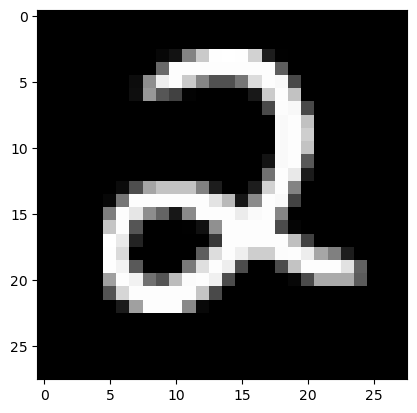

In [752]:
idx = 56

image_sample, label = test[idx]

y_pred = lenet(image_sample[None, :].to(device))

plt.imshow(image_sample.squeeze(), cmap='gray')

y_mapping = {i: yi.item() for i, yi in enumerate(y_pred.cpu()[0])}

y_mapping

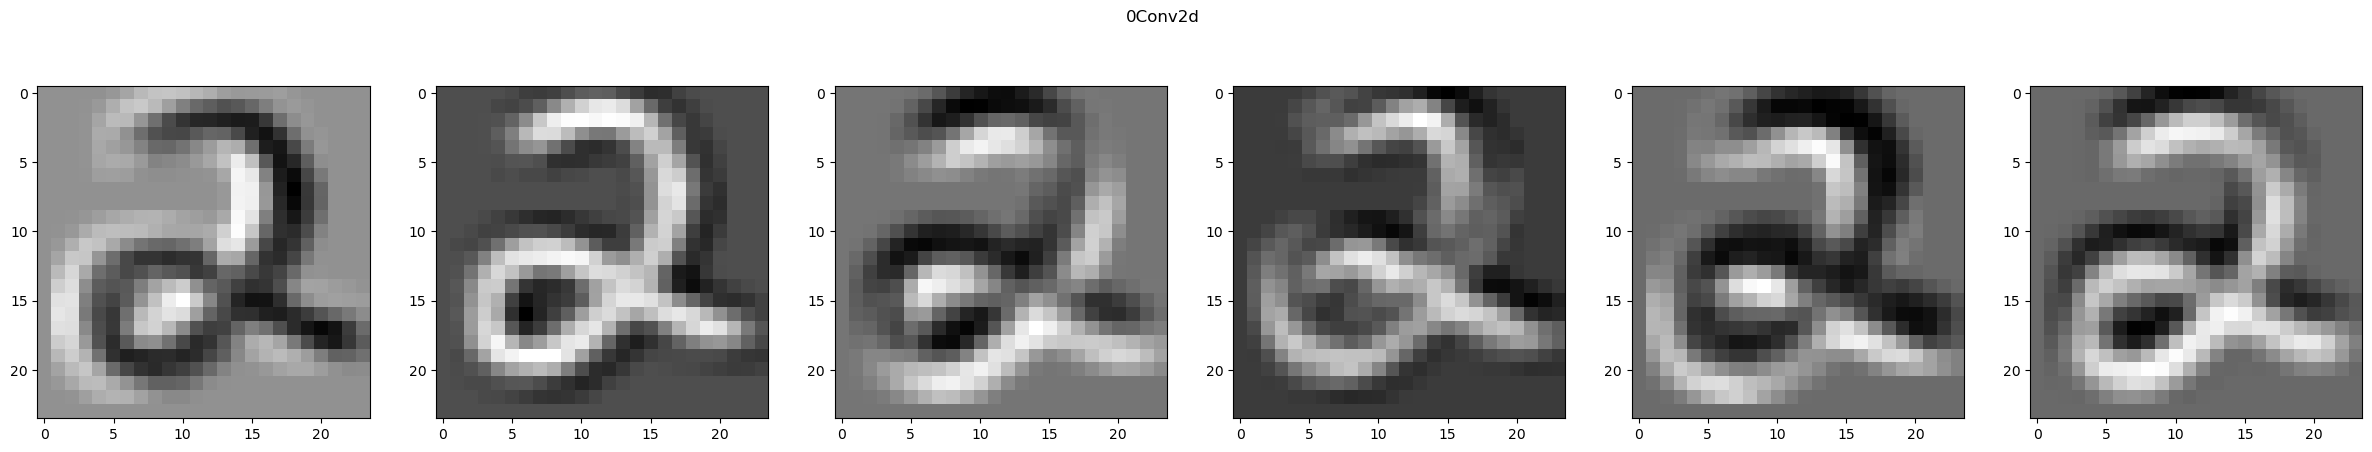

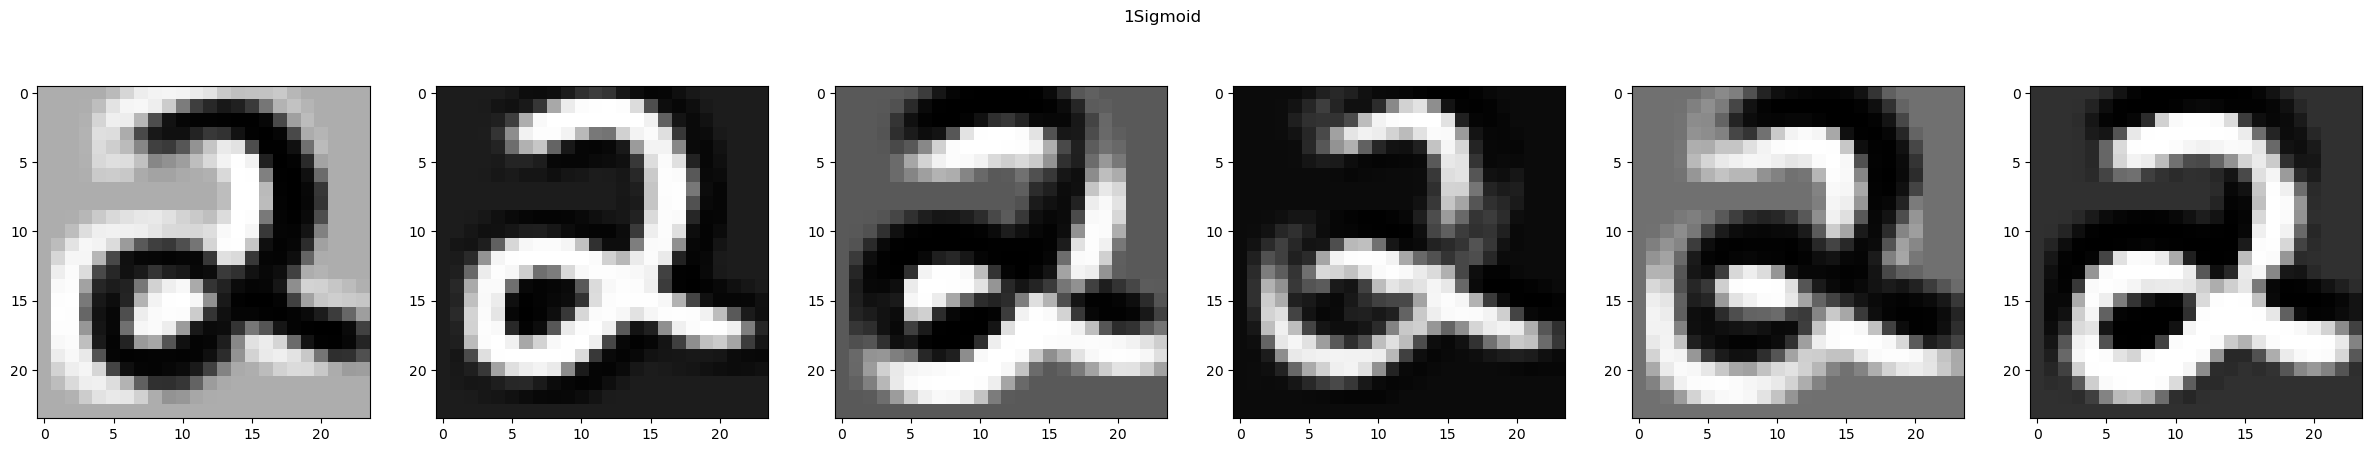

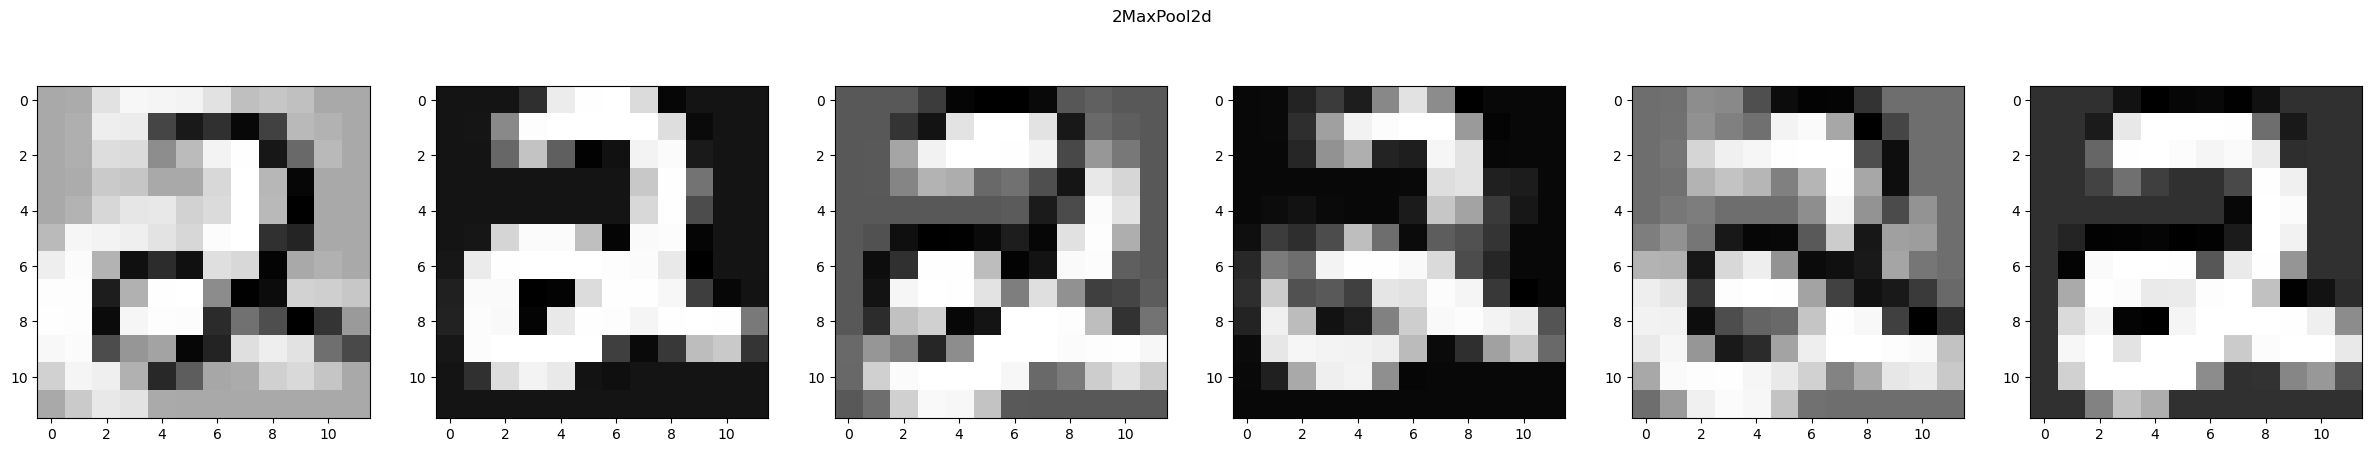

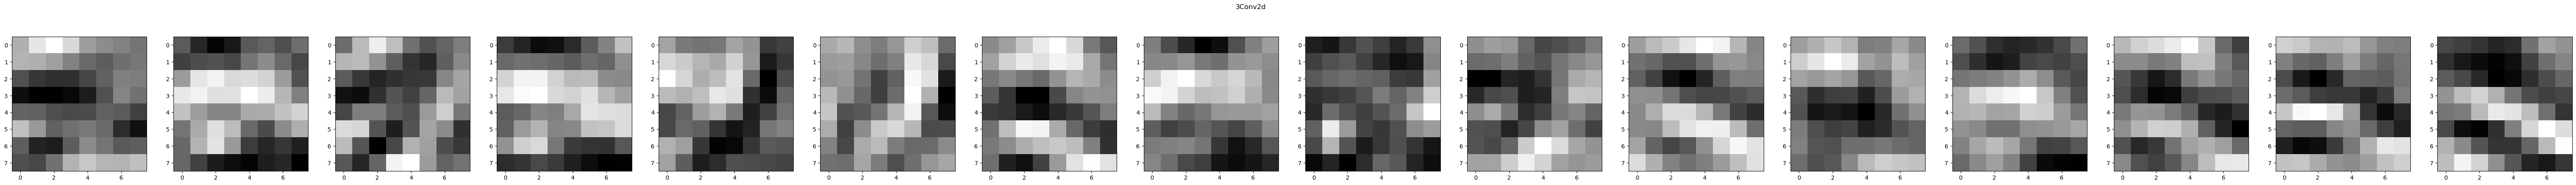

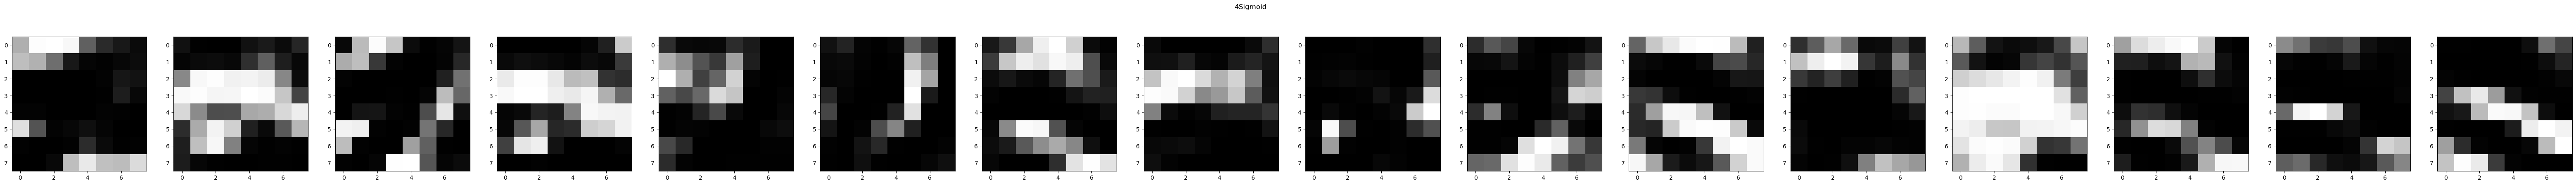

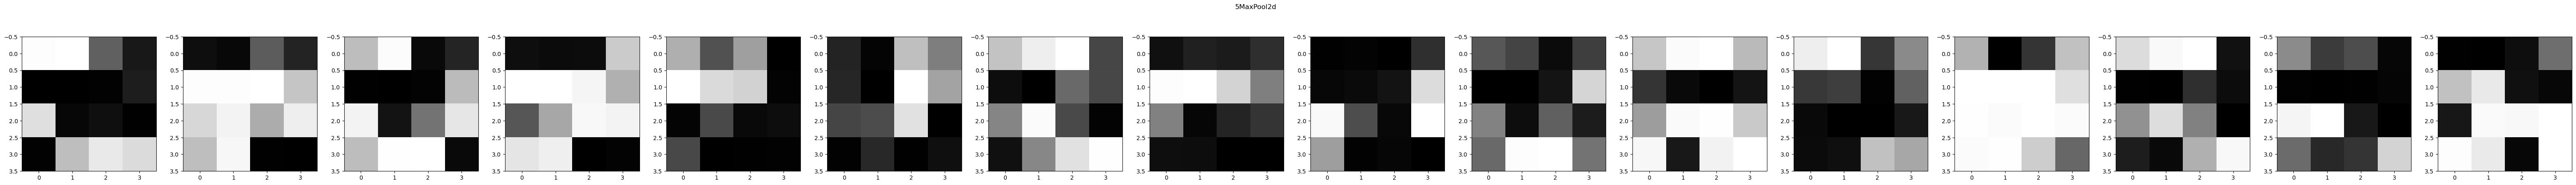

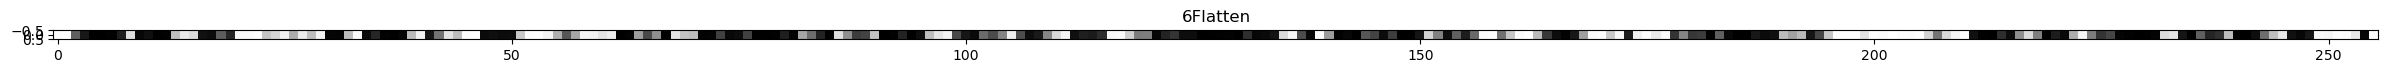

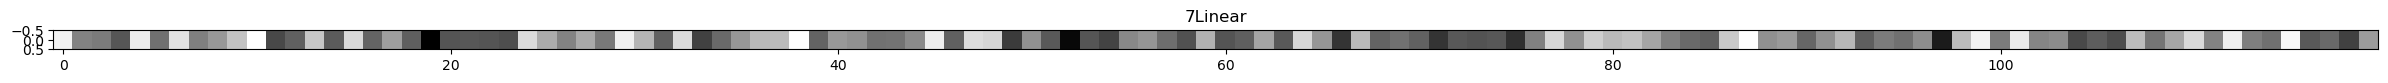

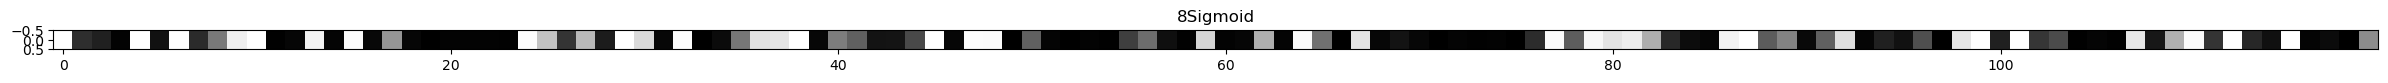

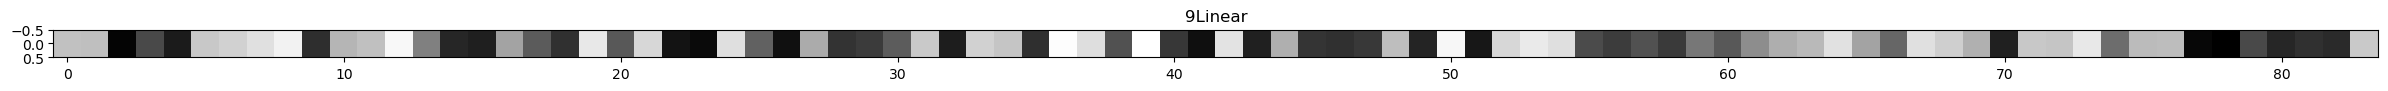

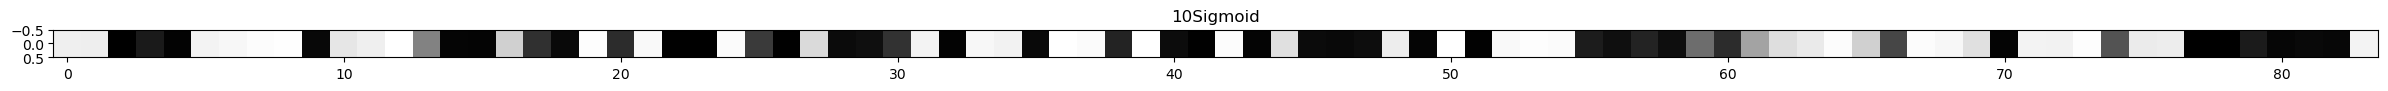

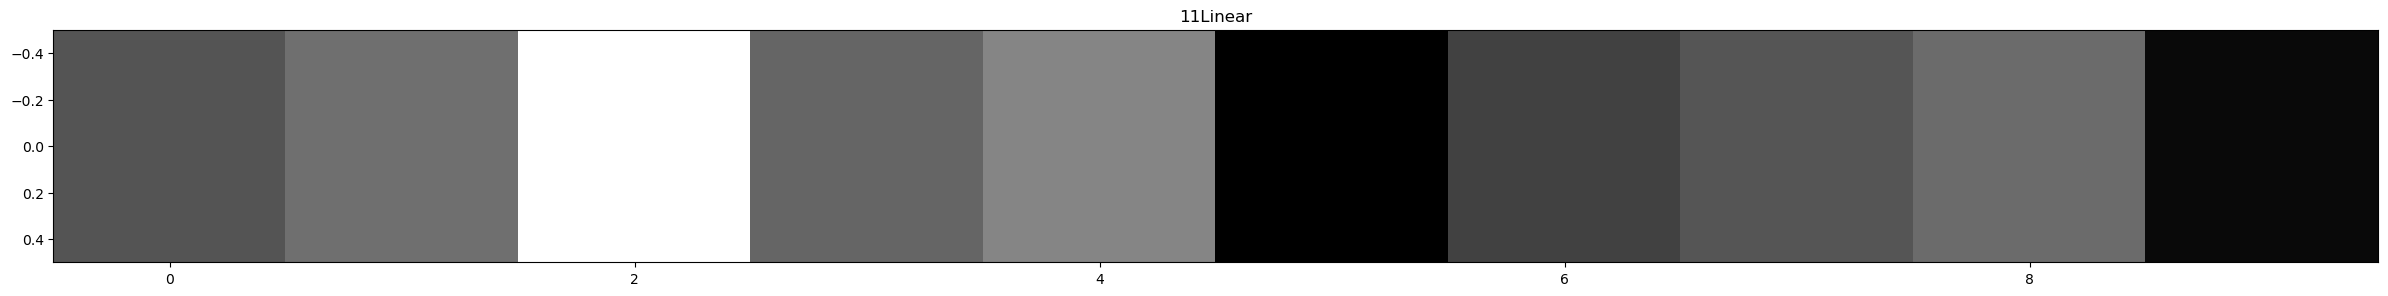

In [753]:
for name in features.keys():
    tensor = features[name].squeeze()
    if len(tensor.shape) > 1:
        fig, axes = plt.subplots(1, tensor.shape[0], figsize=(tensor.shape[0]*5, 5))
        axes = axes.flatten()
        fig.suptitle(name)
        for ax, conv_val in zip(axes, tensor):
            ax.imshow(conv_val.cpu().detach(), cmap='gray')
    else:
        plt.figure(figsize=(30, 5))
        plt.title(name)
        plt.imshow(tensor[None, :].cpu().detach(), cmap='gray')